In [1]:
from utils.portfolio_trainer import PortfolioOptimization
from pandas import read_csv
from utils.feature_engineer import FeatureEngineer
from utils.helpers import data_split
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
df_dow =read_csv('./data/dow.csv')
df_nasdaq =read_csv('./data/nasdaq.csv')
df_hsi = read_csv('./data/hsi.csv')
df_dax = read_csv('./data/dax.csv')
df_sp500 = read_csv('./data/sp500.csv')

In [2]:
df =df_dow.copy()

In [3]:
# columns = reduced_data.columns.tolist()
df = df_dow[df_dow.tic.isin( ['AAPL', 'AXP', 'DIS', 'GS', 'IBM', 'MMM', 'WBA'])]

In [5]:
TRAIN_START_DATE = '2014-01-01'
TRAIN_END_DATE = '2019-12-30'

VALIDATION_START_DATE = '2020-01-01'
VALIDATION_END_DATE = '2020-12-30'

TEST_START_DATE = '2021-01-01'
TEST_END_DATE = '2024-10-01'
INDICATORS = [
    "close_21_ema",
    "close_62_ema"
    ]

fe = FeatureEngineer(use_technical_indicator=True,
                     tech_indicator_list = INDICATORS,
                     use_turbulence=False,
                     user_defined_feature = True)

processed_dax = fe.preprocess_data(df.query('date>"2013-01-01"'))
cleaned_data = processed_dax.copy()
cleaned_data = cleaned_data.fillna(0)
cleaned_data = cleaned_data.replace(np.inf,0)
train_data = data_split(cleaned_data, TRAIN_START_DATE, TRAIN_END_DATE)
test_data = data_split(cleaned_data, TEST_START_DATE, TEST_END_DATE)
validation_data = data_split(cleaned_data, VALIDATION_START_DATE, VALIDATION_END_DATE)
stock_dimension = len(train_data.tic.unique())
state_space = 1 + 2*stock_dimension + len(INDICATORS)*stock_dimension
print(f"Stock Dimension: {stock_dimension}")


Successfully added technical indicators
Successfully added user defined features
Stock Dimension: 7


In [4]:
pv = train_data.pivot(columns='tic',values='close')
corr = pv.corr()
data = corr.copy()
high_corr_pairs = set()
for i in range(len(corr.columns)):
    for j in range(i):
        if abs(corr.iloc[i, j]) > 0.9:
            col_name = corr.columns[i]
            high_corr_pairs.add(col_name)

# Step 3: Drop one of the correlated columns
reduced_data = data.drop(columns=high_corr_pairs)
print("Original columns:", data.columns.tolist())
print("Columns retained after filtering:", reduced_data.columns.tolist())
reduced_data = reduced_data.drop(high_corr_pairs)
reduced_data.style.background_gradient(cmap='coolwarm')

Original columns: ['AAPL', 'AMGN', 'AXP', 'BA', 'CAT', 'CRM', 'CSCO', 'CVX', 'DIS', 'GS', 'HD', 'HON', 'IBM', 'INTC', 'JNJ', 'JPM', 'KO', 'MCD', 'MMM', 'MRK', 'MSFT', 'NKE', 'PG', 'TRV', 'UNH', 'V', 'VZ', 'WBA', 'WMT']
Columns retained after filtering: ['AAPL', 'AXP', 'DIS', 'GS', 'IBM', 'MMM', 'WBA']


tic,AAPL,AXP,DIS,GS,IBM,MMM,WBA
tic,,,,,,,
AAPL,1.000000,0.828584,0.847921,0.693695,-0.106555,0.683521,-0.293444
AXP,0.828584,1.000000,0.680693,0.517039,0.108471,0.449335,-0.624728
DIS,0.847921,0.680693,1.000000,0.520113,-0.200584,0.463319,-0.135335
GS,0.693695,0.517039,0.520113,1.000000,0.209985,0.784357,0.009485
IBM,-0.106555,0.108471,-0.200584,0.209985,1.000000,-0.045360,-0.260052
MMM,0.683521,0.449335,0.463319,0.784357,-0.045360,1.000000,0.052103
WBA,-0.293444,-0.624728,-0.135335,0.009485,-0.260052,0.052103,1.000000


In [ ]:
def add_volatility(df, periods=21):
    rolling_volatility = df.groupby(
        'tic')['log_return'].rolling(window=periods).std()
    rolling_volatility = rolling_volatility.reset_index(level=0, drop=True)
    # Assign the annualized volatility back to the original DataFrame
    df['volatility'] = rolling_volatility

    # Fill missing values with 0 (first periods will have NaN)
    df['volatility'].fillna(0, inplace=True)

    return df


cleaned_data = add_volatility(cleaned_data)
train_data = data_split(cleaned_data, TRAIN_START_DATE, TRAIN_END_DATE)
test_data = data_split(cleaned_data, TEST_START_DATE, TEST_END_DATE)
validation_data = data_split(cleaned_data, VALIDATION_START_DATE, VALIDATION_END_DATE)
stock_dimension = len(train_data.tic.unique())
state_space = 1 + 2*stock_dimension + len(INDICATORS)*stock_dimension
print(f"Stock Dimension: {stock_dimension}")

In [6]:
from agents.evn_mvo import StockPortfolioEnv
from agents.mvo_agent import MarkowitzAgent

def mean_variance_optimization(data, solver='OSQP', window=1, rf=0.02, pct=0.001, objective='min_variance', multi_objective=False):
    result = {}
    stock_dimension = len(data.tic.unique())
    state_space = stock_dimension
    env_kwargs = {
        "hmax": 100,
        "initial_amount": 50_000,
        "transaction_cost_pct": pct,
        "state_space": state_space,
        "stock_dim": stock_dimension,
        "tech_indicator_list": [],
        "action_space": stock_dimension,
        "reward_scaling": 1e-4,
        "window": window

    }
    test_env = StockPortfolioEnv(df=data, **env_kwargs)
    agent = MarkowitzAgent(test_env, rf=rf, objective=objective, cost=pct,multi_objective=multi_objective)
    mvo_min_variance = agent.prediction(test_env)
    mvo_min_variance["method"] = "markowitz"
    mvo_min_variance.columns = ['date', 'account', 'return', 'method']
    result["test"] = mvo_min_variance
    result["name"] = 'Min Variance Portfolio'
    result["action"] = test_env.actions_memory
    result["date"] = test_env.date_memory

    return result,test_env

In [7]:
from utils.mean_variance_optimization import mvo_data
TEST_START_DATE = '2021-01-01'
TEST_END_DATE = '2024-10-01'
covariances = mvo_data(cleaned_data,[],TEST_START_DATE,TEST_END_DATE)

In [10]:
from pypfopt import EfficientFrontier, objective_functions
list_weights = []
test_data = covariances.query("date > '2021-01-01' & date <'2024-10-01' ")
for i,d in enumerate(test_data.date.unique()):
    ef = EfficientFrontier(test_data[test_data.date == d].iloc[0].returns, test_data[test_data.date == d].iloc[0].cov_list,solver='OSQP')
    ef.min_volatility()
    weights = ef.clean_weights()
    list_weights.append(list(weights.values()))

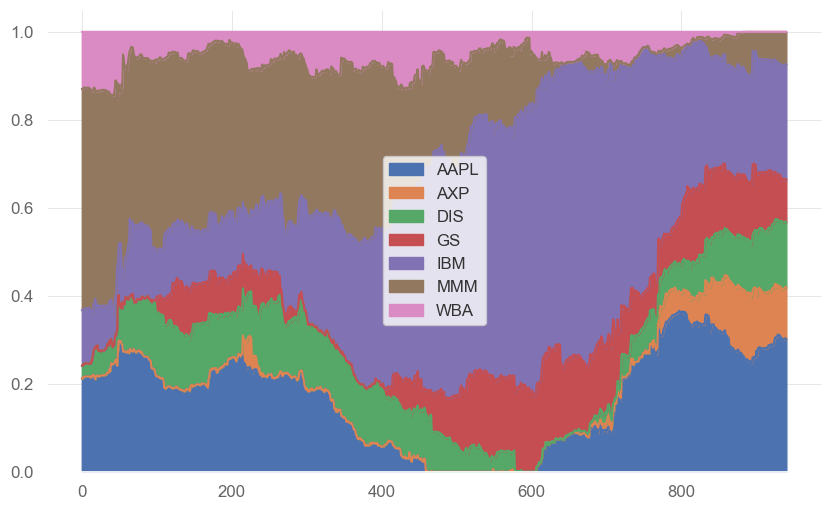

In [11]:
weights = pd.DataFrame(list_weights)
weights.columns =cleaned_data.tic.unique()
weights.plot(kind='area')
plt.show()

In [8]:
res = mean_variance_optimization(covariances,pct=0.003)

begin_total_asset:50000
end_total_asset:66757.40955388216
Sharpe:  0.6356390425171442
Test Finished!
episode_return 1.335148191077643


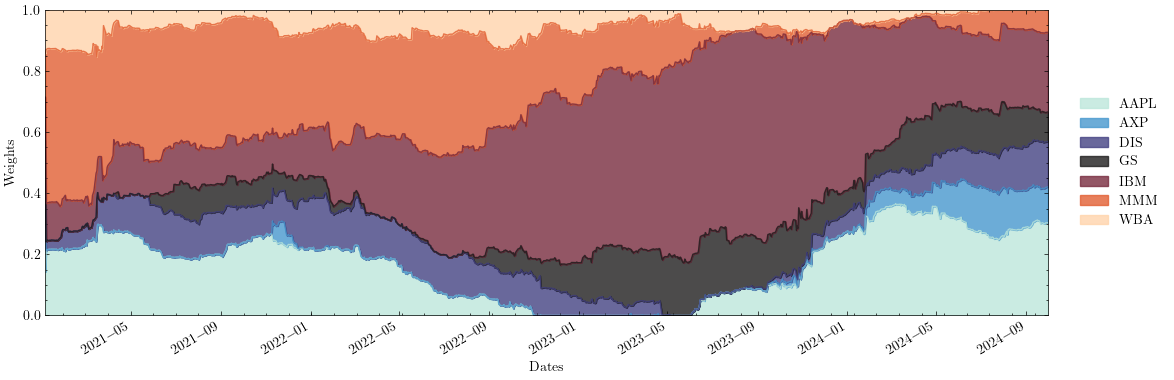

In [9]:
from utils.plotting_helpers import plot_mvo_weights

%matplotlib inline
plot_mvo_weights(res[0],test_data)

In [14]:
a = np.array([1,6,9,84,1])
b = np.array([1,6,9,84,1])
(a-b).tolist()

[0, 0, 0, 0, 0]